<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#K目标邻近" data-toc-modified-id="K目标邻近-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>K目标邻近</a></span><ul class="toc-item"><li><span><a href="#测试数据，进行测试" data-toc-modified-id="测试数据，进行测试-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>测试数据，进行测试</a></span></li><li><span><a href="#sklearn.KNN-验证" data-toc-modified-id="sklearn.KNN-验证-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>sklearn.KNN 验证</a></span></li><li><span><a href="#Iris分类" data-toc-modified-id="Iris分类-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Iris分类</a></span></li><li><span><a href="#Iris-sklearn验证" data-toc-modified-id="Iris-sklearn验证-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Iris sklearn验证</a></span></li></ul></li><li><span><a href="#附录" data-toc-modified-id="附录-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>附录</a></span><ul class="toc-item"><li><span><a href="#函数解释" data-toc-modified-id="函数解释-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>函数解释</a></span><ul class="toc-item"><li><span><a href="#KNeighborsClassifier" data-toc-modified-id="KNeighborsClassifier-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span><code>KNeighborsClassifier</code></a></span></li><li><span><a href="#kneighbors" data-toc-modified-id="kneighbors-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span><code>kneighbors</code></a></span></li><li><span><a href="#sotred()" data-toc-modified-id="sotred()-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>sotred()</a></span></li></ul></li></ul></li></ul></div>

#  K目标邻近

In [78]:
import numpy as np
from IPython.display import Latex
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier as KNN
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# KDTree Node Class
class KDNode:
    
    def __init__(self, sample, featurea_index, left, right):
        self.sample = sample
        self.feature_index = featurea_index
        self.left = left
        self.right = right

In [152]:
# KDTree Class
class KDTree:
    
    def __init__(self, data):
        self.n_feature = data.shape[1] - 1
        self.root = self.Build(data, 0)
        
    def Build(self, data, featurea_index):
        if len(data) == 0:
            return None
        data = sorted(data, key=lambda x:x[featurea_index])
        split_pos = len(data) // 2
        return KDNode(data[split_pos], featurea_index,\
                          self.Build(data[:split_pos], (featurea_index + 1)\
                                     % self.n_feature),\
                          self.Build(data[split_pos + 1 :], (featurea_index + 1) \
                                     % self.n_feature))
    
    # target 将保存所有满足条件的点的集合， 及其距离
    # maxMindist 保存所有邻近点中，最大的距离
    # K 表示要查找的最近邻点的数量
    def _FindKNearby(self, kdnode, source, target, maxMindist, K):
        if kdnode == None:
            # 前三位是坐标 + 标签，第四位是 距离
            return target, float('inf')
        
        # 区分遍历顺序
        pivot = kdnode.sample
        if pivot[kdnode.feature_index] < source[kdnode.feature_index]:
            forword = kdnode.left
            backword =kdnode.right
        else:
            forword = kdnode.right
            backword = kdnode.left
            
        forword_target, forword_maxMindist= self._FindKNearby(forword,\
                                                              source, target, maxMindist, K)
        # 去重
        forword_target = np.unique(forword_target, axis=0)
        # 排序
        target = sorted(forword_target, key=lambda x:x[3])
        # 再次转换为np.narray类型
        target = np.array(target)
        length = min(target.shape[0], K)
        target = forword_target[:length]
        if (length > K):
            maxMindist = forword_target[length - 1][3]
        else:
            maxMindist = float('inf')
        
        to_pivot = np.linalg.norm(source[:-1] - pivot[:-1], ord=2)
        if maxMindist < to_pivot:
            return target, maxMindist
        
        pivot = np.append(pivot ,to_pivot)
        target = np.append(target, [pivot], axis=0)
        
        backword_target, backword_maxMindist = self._FindKNearby(backword, \
                                                                 source, target, maxMindist, K)
        target = np.append(target, backword_target, axis=0)
        maxMindist = backword_maxMindist
        target = np.unique(target, axis=0)
        if target.shape[0] > K:
            target = sorted(target, key=lambda x:x[3])
            target = target[:K]
            maxMindist = target[K - 1][3]
            target = np.array(target)
        
        return target, maxMindist
    
    def KNearest(self, source, K):
        dist = np.linalg.norm(source[:-1] - self.root.sample[:-1])
        target = np.append(self.root.sample, dist)
        # [target] 就是为了将一位的数据转换为二维的数据
        result = self._FindKNearby(self.root, source, [target], float('inf'), K)
        return result[0]

## 测试数据，进行测试

In [153]:
# 最后一列是标签
example_data = np.array([[2, 3, 0],[5, 4, 0],[9, 6, 0],[4, 7, 1],[8, 1, 1],[7, 2, 1],
                        [2, 5, 0],[5, 1, 0],[9, 8, 0],[2, 2, 1],[1, 1, 1],[7, 6, 1],])
example_kdtree = KDTree(example_data)

In [154]:
# 先根序列打印KDtree
def print_kDTree(root):
    if root == None:
        return
    print(root.sample)
    print_kDTree(root.left)
    print_kDTree(root.right)
    
print_kDTree(example_kdtree.root)

[5 1 0]
[5 4 0]
[2 2 1]
[1 1 1]
[2 3 0]
[4 7 1]
[2 5 0]
[7 6 1]
[8 1 1]
[7 2 1]
[9 8 0]
[9 6 0]


[[5.         4.         0.         1.41421356]
 [2.         5.         0.         2.        ]
 [4.         7.         1.         2.        ]
 [2.         3.         0.         2.82842712]
 [7.         6.         1.         3.16227766]]


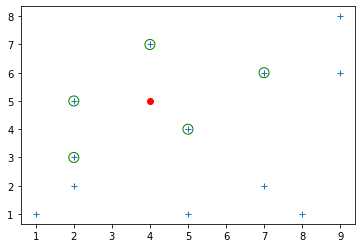

In [158]:
source = np.array([4, 5, 1])
KNearest = example_kdtree.KNearest(source, 5)
print(KNearest)

plt.plot(source[0], source[1], 'ro', label='Source')
plt.plot(example_data[:, 0], example_data[:, 1], '+', label="Point")
plt.scatter(KNearest[:, 0], KNearest[:, 1],  color='',\
         marker='o', edgecolors='g', s=100, label='Target')

## sklearn.KNN 验证

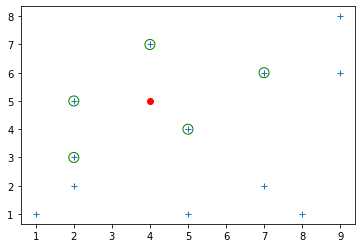

In [156]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(example_data)
# 返回值为最邻近的K个点的索引及其距离
source = np.array([[4, 5, 1]])
KNeights = neigh.kneighbors(source)[1]

K_neight_points = example_data[KNeights][0]
# 可视化
plt.plot(source[0][0], source[0][1], 'ro', label='Source')
plt.plot(example_data[:, 0], example_data[:, 1], '+', label="Point")
plt.scatter(K_neight_points[:, 0], K_neight_points[:, 1],  color='',\
         marker='o', edgecolors='g', s=100, label='Target')

## Iris分类

In [163]:
# 导入加载数据集
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

In [164]:
#取出前 100 条经录， 并且将其划分为训练集与标签两部分
'''
iloc，即index locate 用index索引进行定位，所以参数是整型，如：df.iloc[10:20, 3:5]
loc，则可以使用column名和index名进行定位，如：df.loc[‘image1’:‘image10’, ‘age’:‘score’]
'''
data = np.array(iris_df.iloc[:100, [0, 1, -1]])
X, Y = data[:, :-1],data[:, -1]

In [168]:
# 训练Iris_KDTree, 找出距离最近的 5 个点
Iris_KDTree = KDTree(data)
iris_source = np.array([5.0, 3.6, 0])
KNearest = Iris_KDTree.KNearest(iris_source, 7)
# 打印相关数据
print(KNearest)

[[5.         3.6        0.         0.        ]
 [4.9        3.6        0.         0.1       ]
 [5.         3.5        0.         0.1       ]
 [5.1        3.5        0.         0.14142136]
 [5.1        3.7        0.         0.14142136]
 [5.         3.4        0.         0.2       ]
 [5.1        3.8        0.         0.2236068 ]]


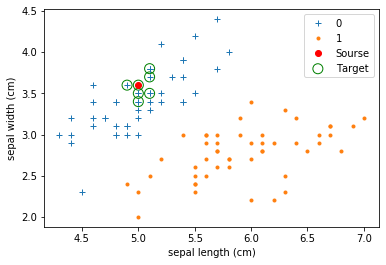

In [169]:
# 可视化验证数据 -- 查看数据集，并能够做下一步的操作
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.plot(iris_source[0], iris_source[1], 'ro', label='Sourse')
plt.scatter(KNearest[:, 0], KNearest[:, 1], color='',\
            marker='o', edgecolors='g', s=100, label='Target')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

## Iris sklearn验证

[[5.  3.6 0. ]
 [4.9 3.6 0. ]
 [5.  3.5 0. ]
 [5.  3.5 0. ]
 [5.1 3.5 0. ]
 [5.1 3.7 0. ]
 [5.1 3.5 0. ]]


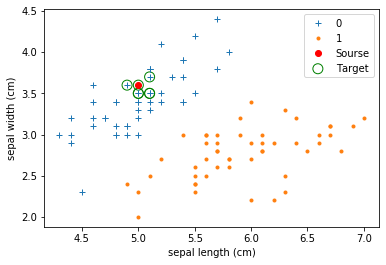

In [170]:
from sklearn.neighbors import NearestNeighbors
iris_KNeights_model = NearestNeighbors(n_neighbors=7)
iris_KNeights_model.fit(data)
# 获取最近点的索引
iris_KNeights = iris_KNeights_model.kneighbors([[5.0, 3.6, 0]])[1]
# nearest_point
nearest_point = data[iris_KNeights][0]
print(nearest_point)
# 可视化
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.plot(iris_source[0], iris_source[1], 'ro', label='Sourse')
plt.scatter(nearest_point[:, 0], nearest_point[:, 1], color='',\
            marker='o', edgecolors='g', s=100, label='Target')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

# 附录
## 函数解释
### `KNeighborsClassifier`
```py
def KNeighborsClassifier(n_neighbors = 5,
                       weights='uniform',
                       algorithm = '',
                       leaf_size = '30',
                       p = 2,
                       metric = 'minkowski',
                       metric_params = None,
                       n_jobs = None
                       )
```
-`n_neighbors`：这个值就是指 KNN 中的 “K”了。前面说到过，通过调整 K 值，算法会有不同的效果。
- `weights`（权重）：最普遍的 KNN 算法无论距离如何，权重都一样，但有时候我们想搞点特殊化，比如距离更近的点让它更加重要。这时候就需要 weight 这个参数了，这个参数有三个可选参数的值，决定了如何分配权重。参数选项如下：
        • 'uniform'：不管远近权重都一样，就是最普通的 KNN 算法的形式。
        • 'distance'：权重和距离成反比，距离预测目标越近具有越高的权重。
        • 自定义函数：自定义一个函数，根据输入的坐标值返回对应的权重，达到自定义权重的目的。
- `algorithm`：在 sklearn 中，要构建 KNN 模型有三种构建方式，1. 暴力法，就是直接计算距离存储比较的那种放松。2. 使用 kd 树构建 KNN 模型 3. 使用球树构建。 其中暴力法适合数据较小的方式，否则效率会比较低。如果数据量比较大一般会选择用 KD 树构建 KNN 模型，而当 KD 树也比较慢的时候，则可以试试球树来构建 KNN。参数选项如下：
        • 'brute' ：蛮力实现
        • 'kd_tree'：KD 树实现 KNN
        • 'ball_tree'：球树实现 KNN 
        • 'auto'： 默认参数，自动选择合适的方法构建模型
不过当数据较小或比较稀疏时，无论选择哪个最后都会使用 'brute'
        
- `leaf_size`：如果是选择蛮力实现，那么这个值是可以忽略的，当使用KD树或球树，它就是是停止建子树的叶子节点数量的阈值。默认30，但如果数据量增多这个参数需要增大，否则速度过慢不说，还容易过拟合。
- `p`：和metric结合使用的，当metric参数是"minkowski"的时候，p=1为曼哈顿距离， p=2为欧式距离。默认为p=2。
- `metric`：指定距离度量方法，一般都是使用欧式距离。
        • 'euclidean' ：欧式距离
        • 'manhattan'：曼哈顿距离
        • 'chebyshev'：切比雪夫距离
        • 'minkowski'： 闵可夫斯基距离，默认参数
- `n_jobs` ：指定多少个CPU进行运算，默认是-1，也就是全部都算。


### `kneighbors`
`kneighbors（self，X = None，n_neighbors = None，return_distance = True ）`
- 参数
    - `metric =='precomputed'`，则为类似X的数组，形状为（n_queries，n_features）或（n_queries，n_indexed）查询点。如果未提供，则返回每个索引点的邻居。在这种情况下，查询点不被视为其自身的邻居。
    - `n_neighbors int` 要获取的邻居数（默认值为传递给构造函数的值）。
    - `return_distance bool`，可选。默认为True。如果为False，则不会返回距离
- 返回值 
    - `neigh_dist` 数组，形状（n_queries，n_neighbors）表示点的长度的数组，仅当return_distance = True时存在
    - `neigh_ind` 数组，形状（n_queries，n_neighbors）,人口矩阵中最近点的指标。

###  sotred()
`sorted(iterable, cmp=None, key=None, reverse=False)`

`sorted` 是一个python自带的内置函数，作用是对给定的数组进行排序，
* `iterable` 被排序的可迭代对象
* `cmp` 比较的函数
* `key` 主要是用来进行比较的元素
* `reverse` 排序规则，reverse = True 降序 ， reverse = False 升序（默认）。

\* 特别说明，在 '''sorted''' 排序之后元素的类型转变为了list类型 